In [1]:
import numpy as np
import pandas as pd

import os
import pickle
import glob
import matplotlib.pyplot as plt
import time
import keras
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
import imageio
from scipy import signal
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve, auc
from skimage.transform import resize
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
'''import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:    
    print("You have a GPU enabled.")
else:    
    print("Enable a GPU before running this notebook.")'''

'import tensorflow as tf\nprint("You are using TensorFlow version", tf.__version__)\nif len(tf.config.list_physical_devices(\'GPU\')) > 0:    \n    print("You have a GPU enabled.")\nelse:    \n    print("Enable a GPU before running this notebook.")'

In [3]:
save_figures = False
file_ending = '.png'
model_string = 'NMDA'

dataset_folder = '../data'

models_folder     = os.path.join(dataset_folder, 'Models')
morphology_folder = os.path.join(dataset_folder, 'Morphology')
test_data_folder  = os.path.join(dataset_folder, 'Data_test')
#auxiliary_folder  = os.path.join(dataset_folder, 'Auxiliary')

model_filename           = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__model.h5')
model_metadata_filename  = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__training.pickle')
morphology_filename      = os.path.join(morphology_folder, 'morphology_dict.pickle')
#NN_illustration_filename = os.path.join(auxiliary_folder, 'TCN_7_layers.png')
test_files               = sorted(glob.glob(os.path.join(test_data_folder, '*_128_simulationRuns*_6_secDuration_*')))

print('-----------------------------------------------')
print('finding files: morphology and test data')
print('-----------------------------------------------')
#print('model found          : "%s"' %(model_filename.split('/')[-1]))
print('model metadata found : "%s"' %(model_metadata_filename.split('/')[-1]))
print('morphology found     : "%s"' %(morphology_filename.split('/')[-1]))
print('number of test files is %d' %(len(test_files)))
print('-----------------------------------------------')

-----------------------------------------------
finding files: morphology and test data
-----------------------------------------------
model metadata found : "NMDA_TCN__DWT_7_128_153__training.pickle"
morphology found     : "morphology_dict.pickle"
number of test files is 12
-----------------------------------------------


In [4]:
testing_3 = test_files[1]
experiment_dict = pickle.load(open(testing_3, "rb" ), encoding='latin1')


In [5]:
experiment_dict.keys()
df = pd.DataFrame(experiment_dict)
df

,Params,Results
useActiveDendrites,True,NaN
randomSeed,100511,NaN
collectAndSaveDVTs,True,NaN
numOutputSpikesPerSim,"[5, 7, 0, 0, 0, 12, 0, 0, 0, 2, 31, 8, 6, 19, ...",NaN
averageOutputFrequency,0.776042,NaN
numSimulations,128,NaN
totalSimDurationInSec,6,NaN
num_bas_ex_spikes_per_100ms_range,"[0, 750]",NaN
totalNumSimulationSeconds,768,NaN
allSegmentsLength,"[24.200878230108255, 15.18219623504249, 21.664...",NaN


In [239]:
df_count = df['listOfISIs']

KeyError: 'listOfISIs'

# Definitions for opening files

In [6]:
def large_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def small_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def whole_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma', 'allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode)

    return df
#df_sub = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]

#df_sub.T.apply(pd.Series.explode).reset_index()
# stratify on column for basal/apical - use labelencoder

In [7]:
def multi_df(files, opener):
    lst_df = []
    for file in files:
        lst_df.append(opener(file))
        
    return pd.concat(lst_df)



In [8]:
'''testing = test_files[:3]
dfs = multi_df(testing)''' #testing the definitions

'testing = test_files[:3]\ndfs = multi_df(testing)'

In [9]:
#whole_df = multi_df(test_files, whole_dataframe)

# Creating the Dataframes

In [10]:
dfs = multi_df(test_files, large_dataframe)

In [172]:
dfs

,allSegmentsType,allSegmentsLength,allSegments_DistFromSoma,idx
0,basal,24.2009,23.6851,0
1,basal,15.1822,43.3767,1
2,basal,21.6644,61.8,2
3,basal,21.6644,83.4644,2
4,basal,21.6644,105.129,2
...,...,...,...,...
634,apical,18.7358,146.64,189
635,apical,18.7358,165.375,189
636,apical,22.0852,92.1071,190
637,apical,36.0978,121.199,191


In [11]:
df_193 = multi_df(test_files, small_dataframe)

In [12]:
dfs['idx'] = dfs['allSegments_SectionInd']
dfs.drop('allSegments_SectionDistFromSoma', inplace = True, axis=1)
dfs.drop('allSegments_SectionInd', inplace = True, axis=1)
df_193['idx'] = df_193.index
#dfs.rename(columns={'index':'idx'}, inplace=True)
df_193.rename(columns={'index':'idx'}, inplace=True)


# dfs = iterates through 639 items - Segments - I have a column that shows the idx of df_193
# df_193 = iterates through 193 items - Sections
df_193.drop('allSectionsLength', inplace = True, axis=1)

In [13]:

dfs['idx']=dfs['idx'].astype(float).astype(int)

df_m = dfs.merge(df_193.drop_duplicates(), how= 'inner', left_on=['idx'],right_on =['idx'])
#test10 = dfs.join(df_193.set_index('idx'), on='idx')
#test10 = pd.merge_ordered(dfs, df_193, fill_method="ffill", left_by="idx")


In [14]:
df_m.drop('idx', inplace = True, axis=1)

In [15]:
df_m.drop('allSectionsType', inplace = True, axis=1)

In [52]:
le = LabelEncoder()
df_m['allSegmentsType'] = le.fit_transform(df_m['allSegmentsType'])
#1 = Basal
#0 = apical
df_x = df_m.copy(deep=True)

,allSegmentsType,allSegmentsLength,allSegments_DistFromSoma,allSections_DistFromSoma
0,1,24.2009,23.6851,11.5847
1,1,24.2009,23.6851,11.5847
2,1,24.2009,23.6851,11.5847
3,1,24.2009,23.6851,11.5847
4,1,24.2009,23.6851,11.5847
...,...,...,...,...
7663,0,30.0747,118.187,103.15
7664,0,30.0747,118.187,103.15
7665,0,30.0747,118.187,103.15
7666,0,30.0747,118.187,103.15


In [50]:
val0 = df_m[df_m['allSegmentsType'] == 0] #4524

In [128]:
y = df_m['allSegmentsType']

0       1
1       1
2       1
3       1
4       1
       ..
7663    0
7664    0
7665    0
7666    0
7667    0
Name: allSegmentsType, Length: 7668, dtype: int64

In [54]:
df_x.drop('allSegmentsType', inplace = True, axis=1)

In [55]:
X = df_x


# Logistic Regression - Baseline

In [74]:
X

,allSegmentsLength,allSegments_DistFromSoma,allSections_DistFromSoma
0,24.2009,23.6851,11.5847
1,24.2009,23.6851,11.5847
2,24.2009,23.6851,11.5847
3,24.2009,23.6851,11.5847
4,24.2009,23.6851,11.5847
...,...,...,...
7663,30.0747,118.187,103.15
7664,30.0747,118.187,103.15
7665,30.0747,118.187,103.15
7666,30.0747,118.187,103.15


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)

In [76]:
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

In [77]:
(model.predict(X_test) == y_test).mean()

0.975898854207823

In [78]:
model.classes_

array([0, 1])

In [79]:
model.intercept_

array([7.29715813])

In [80]:
model.coef_

array([[-0.05868805,  0.00927583, -0.06029253]])

In [81]:
model.predict_proba(X_train)

array([[1.61818840e-01, 8.38181160e-01],
       [2.43798586e-01, 7.56201414e-01],
       [3.03933095e-02, 9.69606691e-01],
       ...,
       [9.99357698e-01, 6.42302343e-04],
       [9.99998662e-01, 1.33811070e-06],
       [1.00000000e+00, 6.87541016e-20]])

In [82]:
model.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0])

In [83]:
model.score(X_test, y_test)

0.975898854207823

In [84]:
model.score(X_test, y_test)

0.975898854207823

In [85]:
confusion_matrix(y_test, model.predict(X_test))

array([[1446,   55],
       [   6, 1024]])

In [86]:
confusion_matrix(y_train, model.predict(X_train))

array([[2898,  125],
       [   6, 2108]])

-True negatives in the upper-left position

-False negatives in the lower-left position

-False positives in the upper-right position

-True positives in the lower-right position

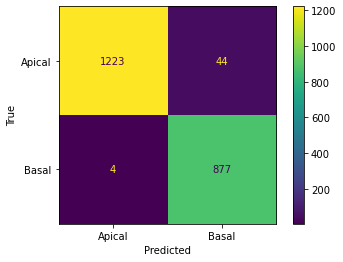

In [112]:
 
labels = ['Apical', 'Basal']
plot_confusion_matrix(model, X_test, y_test)

plt.xticks(np.arange(2), labels) 
plt.yticks(np.arange(2), labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [113]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3257
           1       0.94      1.00      0.97      2263

    accuracy                           0.97      5520
   macro avg       0.97      0.98      0.97      5520
weighted avg       0.98      0.97      0.97      5520



In [114]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1267
           1       0.95      1.00      0.97       881

    accuracy                           0.98      2148
   macro avg       0.97      0.98      0.98      2148
weighted avg       0.98      0.98      0.98      2148



# Logistic Regression with Cross-Validation


In [151]:
from sklearn.linear_model import LogisticRegressionCV

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y,test_size=0.33)

clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
clf.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0])

In [153]:
clf.score(X_test, y_test)

0.9748603351955307

In [191]:
print(classification_report(y_test_cv, model.predict(X_test_cv)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1487
           1       0.94      1.00      0.97      1044

    accuracy                           0.97      2531
   macro avg       0.97      0.97      0.97      2531
weighted avg       0.97      0.97      0.97      2531



In [195]:

from sklearn import metrics
from sklearn.metrics import plot_roc_curve,precision_recall_curve, plot_precision_recall_curve

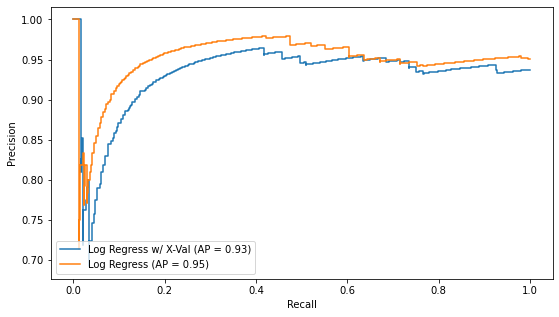

In [207]:
fig, ax = plt.subplots(figsize=(9, 5)) 
plot_precision_recall_curve(clf, X_test_cv, y_test_cv, ax = plt.gca(), name ='Log Regress w/ Cross-Val' ) 

plot_precision_recall_curve(model, X_test, y_test,ax = plt.gca(), name = 'Log Regress' ) 

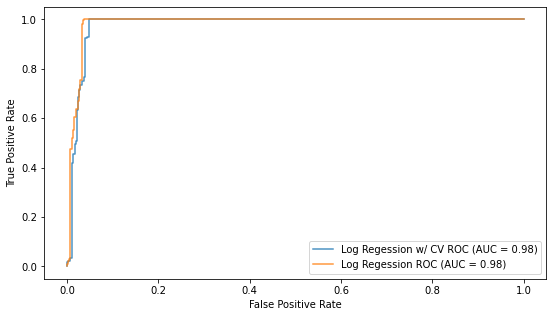

In [208]:
fig, ax = plt.subplots(figsize=(9, 5))
plot_roc_curve(clf, X_test_cv, y_test_cv, ax=plt.gca(), alpha=0.8, name = 'Log Regession w/ CV ROC')
plot_roc_curve(model, X_test, y_test, ax=plt.gca(), alpha=0.8, name = 'Log Regession ROC')
plt.show() 

# Finding K-Means

In [209]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [210]:
X_traink, X_testk, y_traink, y_testk = train_test_split(X, y, stratify=y, test_size=0.28)

In [211]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_traink)
    kmeanModel.fit(X_traink)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X_traink.shape[0])
    
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_traink, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_traink.shape[0]
    mapping2[k] = kmeanModel.inertia_

   - Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
   - Inertia: It is the sum of squared distances of samples to their closest cluster center.

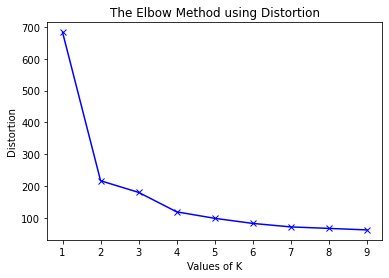

In [212]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()
#plt.savefig('../img/elbow_distort.png')

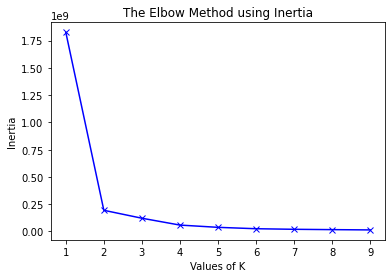

In [213]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()
#plt.savefig('../img/elbow_inertia.png')

# K-Nearest Classifier

In [ ]:
df_new = dfs.copy(deep=True)

In [235]:
le = LabelEncoder()
df_new['allSegmentsType'] = le.fit_transform(dfs['allSegmentsType'])
#1 = Basal
#0 = apical
df_x = df_m.copy(deep=True)

,allSegmentsType,allSegmentsLength,allSegments_DistFromSoma,idx
0,basal,24.2009,23.6851,0
1,basal,15.1822,43.3767,1
2,basal,21.6644,61.8,2
3,basal,21.6644,83.4644,2
4,basal,21.6644,105.129,2
...,...,...,...,...
634,apical,18.7358,146.64,189
635,apical,18.7358,165.375,189
636,apical,22.0852,92.1071,190
637,apical,36.0978,121.199,191


In [231]:
X_trainkc, X_testkc, y_trainkc, y_testkc = train_test_split(X, y,stratify=y, test_size=0.2)

In [232]:
kN = KNeighborsClassifier(n_neighbors=2)
kN.fit(X_trainkc, y_trainkc)

KNeighborsClassifier(n_neighbors=2)

In [233]:
pred = kN.predict(X_testkc)
kN.score(X_testkc, y_testkc)

1.0

In [234]:
confusion_matrix(y_testkc, kN.predict(X_testkc))

array([[905,   0],
       [  0, 629]])

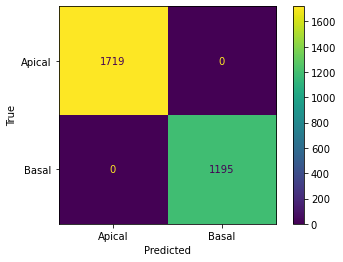

<Figure size 432x288 with 0 Axes>

In [230]:

labels = ['Apical', 'Basal']
plot_confusion_matrix(kN, X_testkc, y_testkc)

plt.xticks(np.arange(2), labels) 
plt.yticks(np.arange(2), labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('../img/confusion_kN.png')

In [219]:
print(classification_report(y_testkc, kN.predict(X_testkc)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1131
           1       1.00      1.00      1.00       786

    accuracy                           1.00      1917
   macro avg       1.00      1.00      1.00      1917
weighted avg       1.00      1.00      1.00      1917

